## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('election.csv', index_col=[0,1])

In [2]:
simplify = lambda x: int(x[x.find('№') + 1:])
new_index = pd.MultiIndex.from_tuples([(simplify(tik), simplify(uik)) for tik, uik in df.index], names=['tik', 'uik'])
new_columns = ['nvoter', 'nvoted', 'Amosov', 'Beglov', 'Tikhonova']
old_columns = df.columns[[0, 8, 11, 12, 13]]

In [3]:
data = pd.DataFrame(df[old_columns].values, columns = new_columns, index=new_index)

In [4]:
data['attendance'] = data['nvoted']/data['nvoter']*100

In [5]:
data.head()

nvoter  nvoted  Amosov  Beglov  Tikhonova  attendance
tik uik                                                       
1   1      1803     575     110     345        120   31.891292
    2      1466     425      53     326         46   28.990450
    3      2092     583     155     332         96   27.868069
    4      1056     309      67     171         71   29.261364
    5      1827     485     137     266         82   26.546251

- явку (%) по всем ТИК, результат отсортировать по убыванию

In [6]:
#macro-averaging
data['attendance'].groupby('tik').mean().sort_values(ascending=False)

tik
18    51.403167
15    49.268268
13    43.801869
30    40.884777
19    38.481687
2     37.620132
8     37.232256
23    36.790396
20    35.377543
22    35.055449
28    32.820550
1     32.407386
4     32.306425
9     32.163636
29    32.046683
21    31.917832
17    31.479702
24    31.203071
10    29.571517
7     28.628103
11    28.527966
16    28.244321
25    28.149335
26    27.757233
14    26.936866
5     26.899423
3     26.685753
12    26.129134
27    25.975296
6     24.379825
Name: attendance, dtype: float64

In [7]:
#micro-averaging
(data['nvoted'].groupby('tik').sum()/data['nvoter'].groupby('tik').sum()).sort_values(ascending=False) * 100

tik
18    49.598661
15    38.887784
13    38.486081
19    37.260688
8     34.695419
20    32.697353
9     32.533716
22    31.489071
30    30.952381
2     30.737680
1     30.145958
10    29.746707
4     29.464766
29    29.378246
21    28.418639
7     28.200960
25    28.113792
17    27.428579
16    27.125936
14    26.581870
28    26.580176
23    26.487978
11    26.015432
5     25.982522
24    25.907143
3     25.646168
12    25.609325
26    25.457989
6     24.346173
27    23.988446
dtype: float64

- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат (%, учитывать участки на которых проголосовало больше 100 человек)

In [8]:
pr_beglov = data[data['nvoted']>100]['Beglov']/data[data['nvoted']>100]['nvoted']
max_idx = pr_beglov.idxmax()
max_value = pr_beglov.max()
print("ТИК №{}, УИК №{}, проголосовавших: {:.2f}%".format(*max_idx, max_value * 100))
print("Доказательство: ", data.loc[max_idx].astype(int), sep='\n')

ТИК №22, УИК №403, проголосовавших: 98.05%
Доказательство: 
nvoter        668
nvoted        665
Amosov          6
Beglov        652
Tikhonova       7
attendance     99
Name: (22, 403), dtype: int32


- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна

In [9]:
difference = data['attendance'].groupby('tik').max() - data['attendance'].groupby('tik').min()
print("Наибольшая разница на {} ТИКе: {:.2f}%".format(difference.idxmax(), difference.max()))

Наибольшая разница на 11 ТИКе: 80.75%


- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)

In [10]:
data['attendance'].groupby('tik').var()

tik
1     188.133458
2     456.180020
3      69.108981
4     221.862618
5     131.018165
6      18.510552
7      63.873858
8     222.281371
9     112.210987
10     74.900375
11    234.094658
12     31.018136
13    370.817654
14     29.995824
15    383.830541
16    102.581810
17    313.288501
18    238.953822
19    207.825797
20    164.346682
21    301.413929
22    416.765838
23    577.819994
24    263.010286
25      8.043611
26    192.770708
27    187.488823
28    369.688448
29    235.520634
30    500.703138
Name: attendance, dtype: float64

- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат

In [11]:
pr = (data[['Beglov', 'Amosov', 'Tikhonova']].div(data['nvoted'], axis=0)*100).astype(int)
percents = pd.DataFrame(index=list(range(0, 101)))
for cand in pr.columns:
    percents[cand] = pr[cand].value_counts()
percents = percents.fillna(0).astype(int)
percents

,Beglov,Amosov,Tikhonova
0,0,4,2
1,0,5,5
2,0,4,7
3,0,9,10
4,0,12,11
5,0,20,20
6,0,31,16
7,0,32,31
8,0,60,30
9,0,69,50


- визуализируйте отношение - явка на УИК  →  результат кандидата

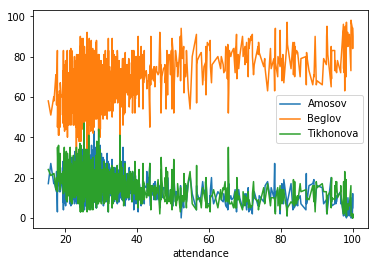

In [13]:
pr['attendance'] = data['attendance']
pr.sort_values(by='attendance').plot(x='attendance', y=['Amosov','Beglov', 'Tikhonova'])